In [73]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [74]:
import numpy as np
import pandas as pd

In [75]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [76]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [77]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [79]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [80]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [81]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [82]:
inspector = inspect(engine)
#inspector.get_table_names()

In [83]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [84]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [85]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# get the 12 month back date
max_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
dt_obj = dt.datetime.strptime(max_date[0], '%Y-%m-%d')


In [86]:
# Calculate the date 1 year ago from the last data point in the database

query_date = dt_obj - dt.timedelta(days=365)
dt1 = str(dt_obj - dt.timedelta(days=365)).split(' ')
query_12mdate = dt1[0]
print (query_12mdate)

2016-08-23


In [87]:
# Perform a query to retrieve the data and precipitation scores
data_precep12m = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_12mdate)

In [88]:
# Save the query results as a Pandas DataFrame and set the index to the date column

Measurment_df = pd.DataFrame(list(data_precep12m), columns = ['date','precipitation'])

Measurment_df.set_index('date',inplace=True)
Measurment_df=Measurment_df.dropna()
Measurment_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [89]:
# Sort the dataframe by date
Measurment_df.sort_values(by=['date'], inplace=True)
Measurment_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


In [90]:
# Use Pandas Plotting with Matplotlib to plot the data


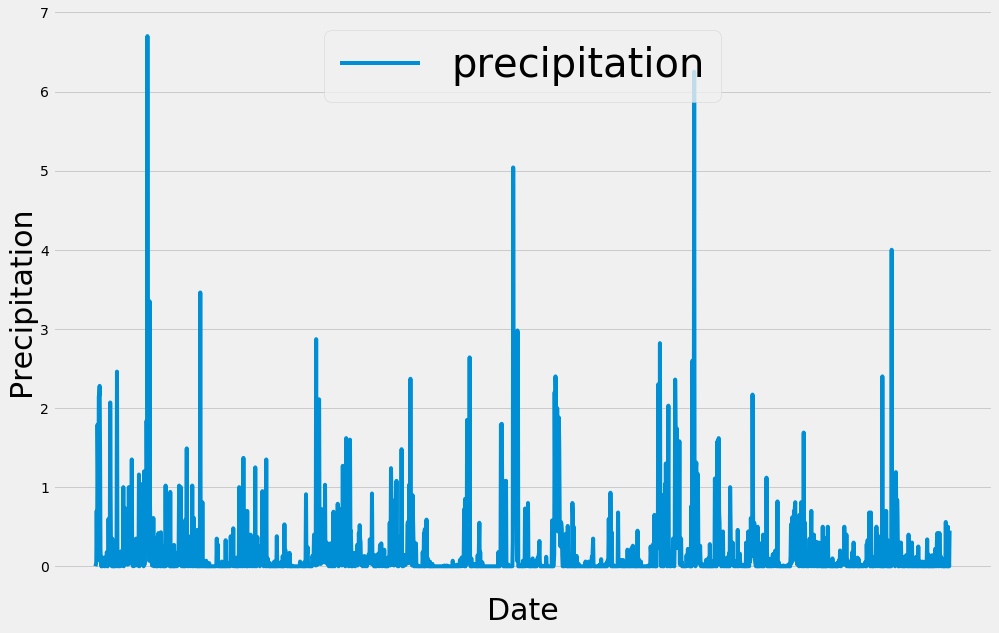

In [91]:
Measurment_df.plot(figsize=(15,10))
plt.ylabel('Precipitation', fontsize=30)
plt.xlabel('Date', fontsize=30)
plt.xticks([])
plt.legend( ["precipitation"],loc="upper center", fontsize=40)
plt.savefig("Images/TripPrecipitationFreq.png")
plt.show()

In [92]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Measurment_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [93]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
station_count

9

In [94]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station_data= session.query(Measurement.station, func.count(Measurement.id) ).group_by(Measurement.station).order_by(func.count(Measurement.id).desc())

for results in active_station_data:
    print(results)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [95]:
# most active station with maximum
most_active_station = active_station_data[0]
most_active_station[0]

'USC00519281'

In [96]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
active_station_data= session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)  ).group_by(Measurement.station).filter(Measurement.station == most_active_station[0])
active_station_data[0]

(54.0, 85.0, 71.66378066378067)

In [97]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station_tobs_data= session.query(Measurement.station, func.count(Measurement.tobs) ).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
active_station_tobs_data[0]

'USC00519281'

In [98]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_tobs_data= session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.station==active_station_tobs_data[0]).\
filter(Measurement.date >= query_12mdate).\
order_by(Measurement.date).all()

df_tobs_12months=pd.DataFrame(station_tobs_data,columns=['date','tobs'])
df_tobs_12months.head()

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


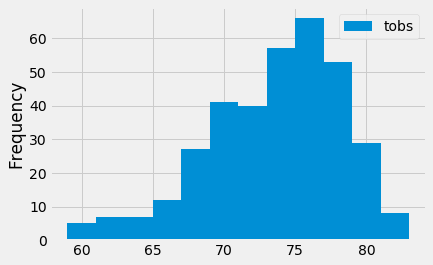

In [99]:
df_tobs_12months.plot.hist(bins=12)
plt.savefig("Images/TOBSFrequency.png")
plt.show()

In [100]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [101]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
selected_temp = calc_temps('2017-03-01', '2017-03-10')
print(selected_temp)


[(62.0, 70.33870967741936, 78.0)]


In [102]:
# create DataFrame wihth the selected  range of dates for last year
selected_temp_df = pd.DataFrame(selected_temp, columns=['tmin', 'tavg', 'tmax'])

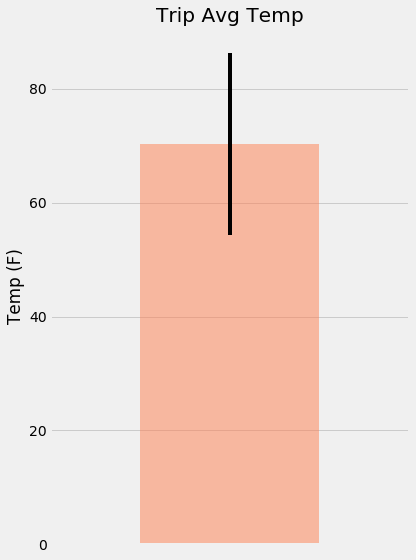

In [103]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
selected_temp_df.plot.bar(y='tavg', yerr=(selected_temp_df['tmax'] - selected_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(6,8))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("Images/TripAvgTemp.png")
plt.show()

In [104]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

print(precipitation('2017-03-01', '2017-03-10'))


[('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.4), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.2), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.12), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.19), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.12), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.59)]


## Optional Challenge Assignment

In [105]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [106]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-03-01'
end_date ='2017-03-10'

# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).\
filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
group_by(Measurement.date).all()

# List comprehension to get the elements in the tuple from the dates query 


# Stip off the year and save a list of %m-%d strings
trip_dates = [x[0] for x in dates] 
trip_dates_stripped= [x[5:] for x in trip_dates]

begin_month_day = trip_dates_stripped[0]
end_month_day = trip_dates_stripped[-1]


# Loop through the list of %m-%d strings and calculate the normals for each date
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                   #     Measurement.date,
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= begin_month_day).filter(func.strftime("%m-%d", Measurement.date) <= end_month_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]

daily_normals = daily_normals[0]
print("Aggregate Daily Normals for 3-01 to 03-10")
daily_normals

Aggregate Daily Normals for 3-01 to 03-10


[(64.0, 70.0327868852459, 76.0),
 (61.0, 70.36666666666666, 78.0),
 (60.0, 70.06896551724138, 78.0),
 (57.0, 69.27272727272727, 77.0),
 (60.0, 67.89090909090909, 76.0),
 (60.0, 69.20338983050847, 76.0),
 (60.0, 69.17241379310344, 78.0),
 (59.0, 68.72413793103448, 78.0),
 (57.0, 68.56140350877193, 75.0),
 (57.0, 69.12280701754386, 75.0)]

In [107]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])

# Add trip_dates to Pandas DataFrame
daily_normals_df['date']= trip_dates

# Change datatype from element to datetime object on Pandas, makes x axis title to add 
daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# Set index to date
daily_normals_df.set_index('date',inplace=True)

daily_normals_df

,tmin,tavg,tmax
date,,,
2017-03-01,64.0,70.032787,76.0
2017-03-02,61.0,70.366667,78.0
2017-03-03,60.0,70.068966,78.0
2017-03-04,57.0,69.272727,77.0
2017-03-05,60.0,67.890909,76.0
2017-03-06,60.0,69.203390,76.0
2017-03-07,60.0,69.172414,78.0
2017-03-08,59.0,68.724138,78.0
2017-03-09,57.0,68.561404,75.0


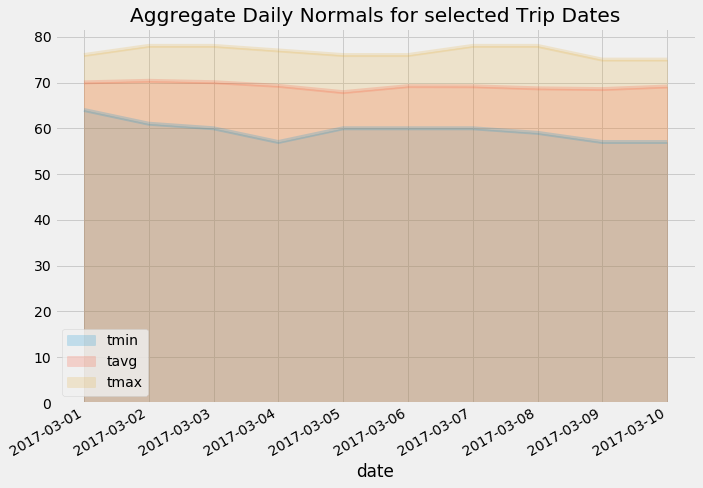

In [108]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, figsize=(10,7), title="Aggregate Daily Normals for selected Trip Dates")
plt.tight_layout()
plt.savefig("Images/DailyNormals.png")
plt.show()